# All Life bank - loan modelling - supervised learning - classification

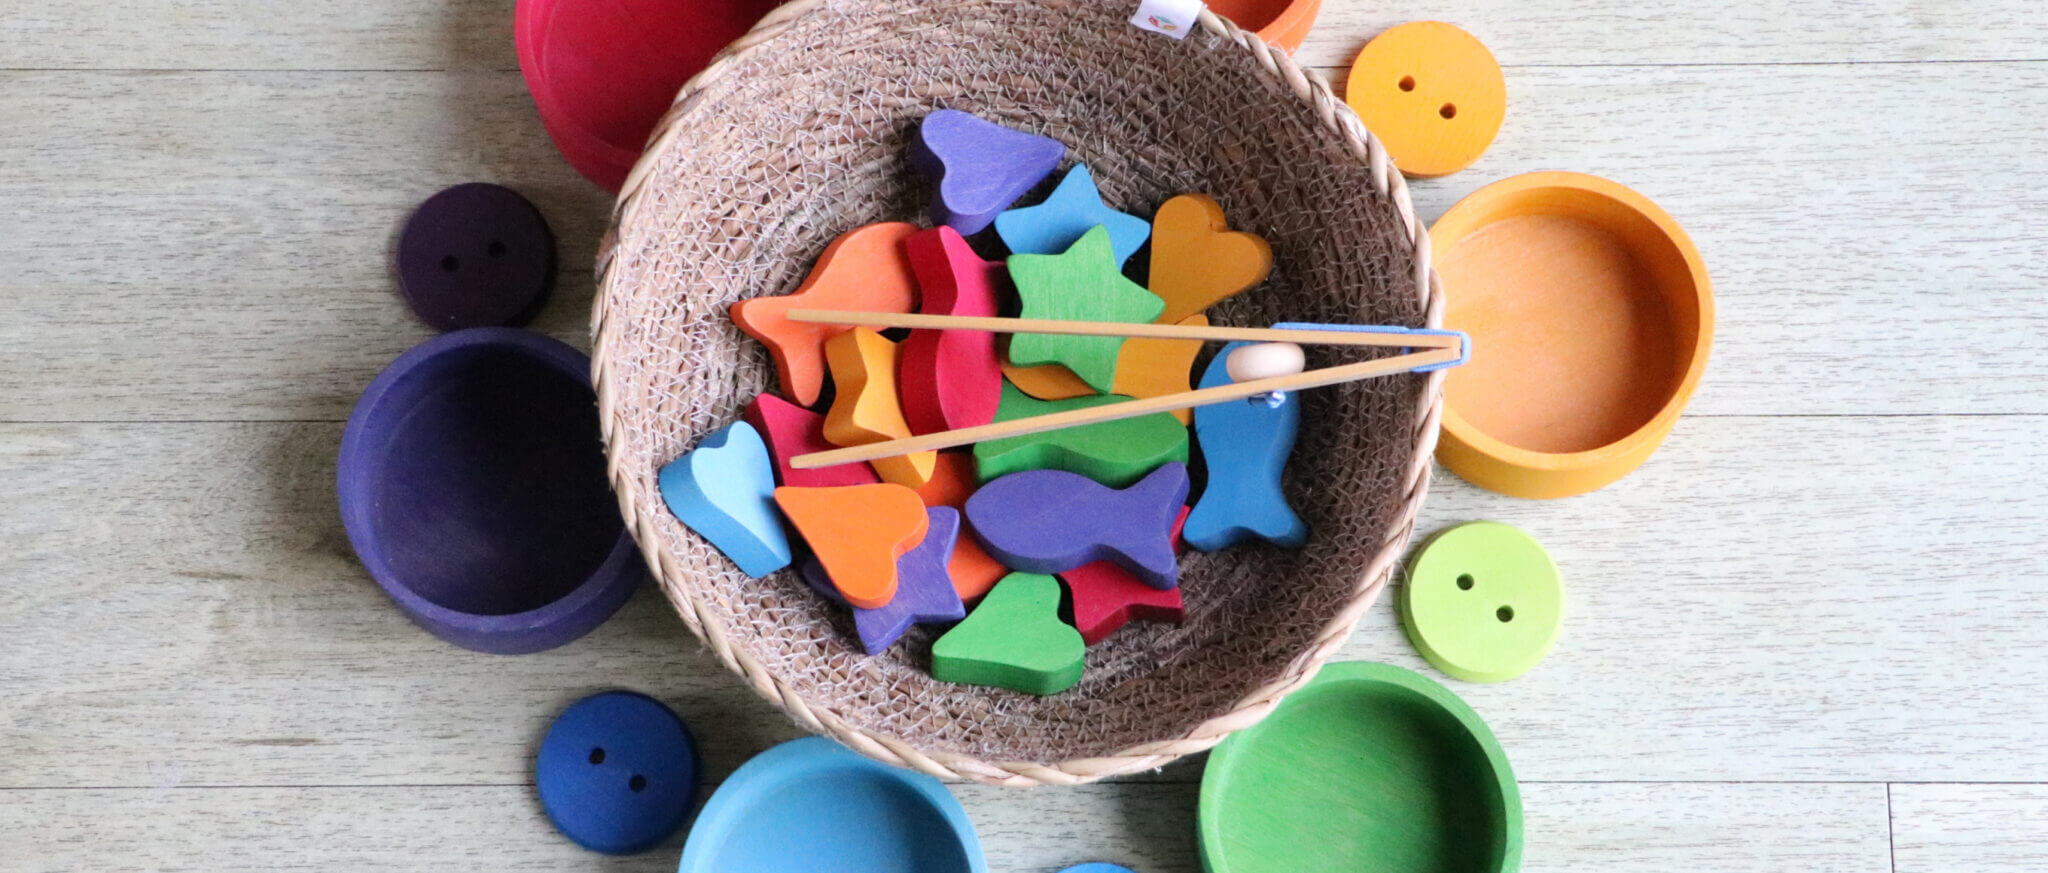

## Context

All Life Bank is a US bank that has a growing customer base. The majority of these customers are liability customers (depositors) with varying sizes of deposits. The number of customers who are also borrowers (asset customers) is quite small, and the bank is interested in expanding this base rapidly to bring in more loan business and in the process, earn more through the interest on loans. In particular, the management wants to explore ways of converting its liability customers to personal loan customers (while retaining them as depositors).

A campaign that the bank ran last year for liability customers showed a healthy conversion rate of over 9% success. This has encouraged the retail marketing department to devise campaigns with better target marketing to increase the success ratio.

You as a Data scientist at AllLife bank have to build a model that will help the marketing department to identify the potential customers who have a higher probability of purchasing the loan.

## Objective
The classification goal is to predict the likelihood of a liability customer buying personal loans which means we have to build a model which will be used to predict which customer will most likely to accept the offer for personal loan, based on the specific relationship with the bank across various features given in the dataset.

### Key questions to be answered

1. To predict whether a liability customer will buy a personal loan or not?
2. Which variables are most significant?
3. Which segment of customers should be targeted more?

### Data Information
The data contains the important demographic and banking details of the customers.

**Attribute Information:**
1. ID: Customer ID
2. Age: Customer’s age in completed years
3. Experience: #years of professional experience
4. Income: Annual income of the customer (in thousand dollars)
5. ZIP Code: Home Address ZIP code.
6. Family: the Family size of the customer
7. CCAvg: Average spending on credit cards per month (in thousand dollars)
8. Education: Education Level. 1: Undergrad; 2: Graduate;3: Advanced/Professional
9. Mortgage: Value of house mortgage if any. (in thousand dollars)
10. Personal_Loan: Did this customer accept the personal loan offered in the last campaign?
11. Securities_Account: Does the customer have securities account with the bank?
12. CD_Account: Does the customer have a certificate of deposit (CD) account with the bank?
13. Online: Do customers use internet banking facilities?
14. CreditCard: Does the customer use a credit card issued by any other Bank (excluding All life Bank)?


## Import required libraries

In [ ]:
# upgrade dependencies
!pip install --upgrade pyflakes

# install zipcode library
!pip install uszipcode

#np black
!pip install nb_black

# commented after first install

In [ ]:
# this will help in making the Python code more structured automatically (good coding practice)
%load_ext nb_black

# Library to suppress warnings or deprecation notes
import warnings

warnings.filterwarnings("ignore")

# Libraries to help with reading and manipulating data
import pandas as pd
import numpy as np

# Library to split data
from sklearn.model_selection import train_test_split

# libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# library to process the zipcode column
import uszipcode as usz
from uszipcode import SearchEngine

# Remove the limit for the number of displayed columns
pd.set_option("display.max_columns", None)

# Set the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

from sklearn import metrics

# Libraries to build Linear Regression Model
from sklearn.linear_model import LogisticRegression

# Libraries to build decision tree classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# To tune different models
from sklearn.model_selection import GridSearchCV

# To get diferent metric scores
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    plot_confusion_matrix,
    make_scorer,
    roc_auc_score,
    precision_recall_curve,
    roc_curve,
)

## Define all required functions

In [ ]:
# function to extract county from the zipcode using searchengine from uszipcode library
def zip_county (zipcode):
    search = SearchEngine(simple_zipcode =  True)
    zip = search.by_zipcode(zipcode)
    return zip.county

# function to extract state from the zipcode using searchengine from uszipcode library
def zip_state (zipcode):
    search = SearchEngine(simple_zipcode =  True)
    zip = search.by_zipcode(zipcode)
    return zip.state

# histogram and boxplot for the feature
def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="orange"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="Winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(data[feature].median(), color="blue", linestyle="-")
    plt.show()  # show the plot

# labeled_barplot
def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage
    plt.show()  # show the plot

# function to plot stacked bar chart
def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    #print(tab1)
    #print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 5, 6))
    plt.legend(
        loc="lower left", frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn_with_threshold(model, predictors, target, threshold=0.5):
    """
    Function to compute different metrics, based on the threshold specified, to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    threshold: threshold for classifying the observation as class 1
    """

    # predicting using the independent variables
    pred_prob = model.predict_proba(predictors)[:, 1]
    pred_thres = pred_prob > threshold
    pred = np.round(pred_thres)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1,
        },
        index=[0],
    )

    return df_perf

# defining a function to plot the confusion_matrix of a classification model built using sklearn
def confusion_matrix_sklearn_with_threshold(model, predictors, target, threshold=0.5):
    """
    To plot the confusion_matrix, based on the threshold specified, with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    threshold: threshold for classifying the observation as class 1
    """
    pred_prob = model.predict_proba(predictors)[:, 1]
    pred_thres = pred_prob > threshold
    y_pred = np.round(pred_thres)

    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

# functions to treat outliers by flooring and capping
def treat_outliers(df, col):
    """
    Treats outliers in a variable

    df: dataframe
    col: dataframe column
    """
    Q1 = df[col].quantile(0.25)  # 25th quantile
    Q3 = df[col].quantile(0.75)  # 75th quantile
    IQR = Q3 - Q1
    Lower_Whisker = Q1 - 1.5 * IQR
    Upper_Whisker = Q3 + 1.5 * IQR

    # all the values smaller than Lower_Whisker will be assigned the value of Lower_Whisker
    # all the values greater than Upper_Whisker will be assigned the value of Upper_Whisker
    df[col] = np.clip(df[col], Lower_Whisker, Upper_Whisker)

    return df

#defining a function to treat all outliers in one go
def treat_outliers_all(df, col_list):
    """
    Treat outliers in a list of variables

    df: dataframe
    col_list: list of dataframe columns
    """
    for c in col_list:
        df = treat_outliers(df, c)

    return df
    
#defining a function to plat precession and recall curves compared to threshold
def plot_prec_recall_vs_tresh(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])
    plt.show()

#defining a fuunction for confusion matrix without threshold
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

#Function to calculate recall score
def get_recall_score(model, predictors, target):
    """
    model: classifier
    predictors: independent variables
    target: dependent variable
    
    """
    prediction = model.predict(predictors)
    return recall_score(target, prediction)

## Load the dataset in dataframe from the file

In [ ]:
# load the file
df = pd.read_csv("../input/personal-loan-customers/Loan_Modelling.csv")

# back up data to preserve the initial version for reference
df_back = df.copy()

## Understand data

### Check the shape of data

In [ ]:
print(f"There are {df.shape[0]} rows and {df.shape[1]} columns.")  # f-string

### List the columns

In [ ]:
# column list
df.columns

### Check the datatypes of columns

In [ ]:
# check the dataset information
df.info()

#### **Observations:**

1. All columns are of number type (int64 / float64)
2. There are no columns with null value

### Check the missing data

In [ ]:
# check number of null records
df.isnull().sum()

**Observations:**

There are no missing values

### Check the duplicate records

In [ ]:
df.duplicated().sum()

**Observations:**

There are no duplicate values

### Check the sample data

In [ ]:
# setting the random seed via np.random.seed to get the same random results every time
np.random.seed(1)

# also look at random 10 sample rows
df.sample(n=10)

### View the first and last 5 rows of the dataset.

In [ ]:
# Display first 5 rows
df.head()

In [ ]:
# Display last 5 rows
df.tail()

**Observations:**

1. ID column is running serial number and there is no additional value in considering this in model building.
2. ZIP Code contains numerical data, but it contains categorical data. We will have to process it and convert it using the uszipcode library.
3. Personal_Loan is our target variable
3. Securities_Account, CD_Account, Online, CreditCard and Personal_Loan are Binary columns depicting whether or not Customer is using/used these facilities.
4. Age, Experience, Income, CCAvg and Mortgage are Continuous features of the dataset.

### Summary of dataset

In [ ]:
# check summary of dataset
df.describe(include='all').T  # transpose for better visibility

**Observations:**

1. The average age of a customer is 45 and the minimum & maximum are 23 and 67 respectively.
2. There are 75% of the customers whose family size is less than or equal to 3.
3. The average annual income of a customer is approximately $73.
4. The minimum experience of a customer is -3 which indicates presence of erroneous data beacuse experience cannot be negative. Such values requires handling.
5. All other data looks OK.

## Feature Re-engineering

### ZIPCode

#### Check the distinct values in the column

In [ ]:
# check the distinct value count
df["ZIPCode"].value_counts()

#### Based on uszipcode library documentation we can find County and State from the zipcode. Lets apply the defined functions and add those values to the dataset for further analysis

In [ ]:
# county column added to dataset using zip_county function
df["County"] = df["ZIPCode"].apply(zip_county)

# State column added to dataset using zip_state function
df["State"] = df["ZIPCode"].apply(zip_state)

#### Check the data after update

In [ ]:
# check the first 5 rows
df.head()

**Observations:**

County and State columns are now added to the dataframe

### Check the distinct values of state column

In [ ]:
# distinct value counts
df["State"].value_counts()

**Observations:**

1. 4966 Rows have CA - California State updated
2. 34 Rows doesn't have any values, it seems the library did not return any values and we have to try to impute those values

#### Lets check the null values of State Column

In [ ]:
# check the count of null values and see the data with missing data in State column
print(df.State.isnull().sum())
df[df.State.isnull()]

**Observations:**

1. All 34 rows with missing state, has County column as NULL as well.
2. Earlier assumption that library did not return the values for state and county was correct.
3. Based on Google Search below are the values that are to be updated
    * Ventura - CA, 93077
    * Irvine - CA, 92717
    * Fullerton - CA, 92634
    * San Francisco - CA, 96651
4. The missing data is also for ZIPCodes starting with 9, this means all the data in this dataset is for California state only.
5. All data being from one state makes the State Column Absolute and we can exclude the same from analysis.
6. However County can be valuable information in our analysis and we can use it for data analysis once the values are updated as per point 3.
7. Also the other attributes of ZIP Code like city and locality if considered for processing will add a lot of variables, hence we can just use County column to do the analysis and find certain patterns based on people belonging to them.

#### Update the County and State columns

In [ ]:
# update data for County and State based on ZIPCodes 
df.loc[df['ZIPCode'] == 92717,["County","State"]] = ["Irvine","CA"]
df.loc[df['ZIPCode'] == 93077,["County","State"]] = ["Ventura","CA"]
df.loc[df['ZIPCode'] == 92634,["County","State"]] = ["Fullerton","CA"]
df.loc[df['ZIPCode'] == 96651,["County","State"]] = ["San Francisco","CA"]

#### Verify the update

In [ ]:
# query the data for the ZIPCode that were updated
df.loc[df['ZIPCode'].isin([92717,93077,92634,96651])]

**Observations:**

1. State and County Columns are updated for missing values.
2. ZIPCode data translation is complete and we can use the new columns for our analysis.

## Data Preprocessing

### Experience

#### We have seen that experience has some negative values and that needs to be corrected.

#### Check the number of records with Negative Experience.

In [ ]:
# check the count of distinct negative values in Experience
df[df['Experience'] < 0]['Experience'].value_counts()

**Observations:**

1. There are 52 rows with negative experience
2. 33 Records have -1, 15 have -2 and 4 have -3 as experience
3. We need to update these rows with related information from the dataset

#### Check the data for the rows with Negative Experience

In [ ]:
# filter rows with negative experience
df[df['Experience'] < 0]

**Observations:**

1. We see that all customers with Negative experience have income more than USD 10,000 per annum.
2. Few customers are earning more than USD 100,000 per annum.
3. All the customers are above 20 years of Age and fall in the earners category.
4. All the customer have at least Under Graduate Degree.
5. Some customers also have Mortgage amounting to more that USD 80,000.
5. It looks like there has been an error in data capture.

#### Check the correlation of Experience with other variables

In [ ]:
# check the correlation of the dataset
df.corr()

**Observations:**

1. Experience is highly correlated with Age.
2. Education is positively correlated with Age.
3. Both Education and Age are factors that impact the experience and we can use data from these columns with Positive values to impute the values of rows where the Experience is negative.
4. From the domain knowledge we also know that Income and Mortgage can also play an important role in imputing the values.

In [ ]:
# Create two different dataframes with records where experience value is greater than 0 and lesser than 0 respectively
# Get the list of Customer IDs from the dataframe containing records with negative experience values
# Iterating over the Customer ID list
    # Get the Age and Education level for the corresponding ID from the negative experience dataframe
    # Filter the records form the positive experience dataframe based on the obtained age and education value
        # calculate the median experience value from the filtered dataframe and store in "experience" variable
        # if the filtered dataframe is empty, filter the negative experience dataframe and obtain the median experience value
    # Replace the negative experience with the absolute value of the median "experience" value


df_positive_experience = df[df['Experience'] > 0]
df_negative_experience = df[df['Experience'] < 0]
negative_experience_id_list = df_negative_experience['ID'].tolist()

for id in negative_experience_id_list:
    age = df.loc[np.where(df['ID']==id)]['Age'].tolist()[0]
    education = df.loc[np.where(df['ID']==id)]['Education'].tolist()[0]
    positive_experience_filtered = df_positive_experience[(df_positive_experience['Age'] == age) &
                                                         (df_positive_experience['Education'] == education)]
    if positive_experience_filtered.empty:
        negative_experience_filtered = df_negative_experience[(df_negative_experience['Age'] == age) &
                                                         (df_negative_experience['Education'] == education)]
        experience = round(negative_experience_filtered['Experience'].median())
    else:
        experience = round(positive_experience_filtered['Experience'].median())
    df.loc[df.ID == id, 'Experience'] = abs(experience)

#### Validate the update

In [ ]:
# check the count
df[df['Experience'] < 0]['Experience'].count()

**Observations:**

There are no records with negative experience

#### Check the dataset info after data pre processing

In [ ]:
df.describe().T

**Observations:**

1. We see the experience data is corrected and minimum experience is now "0" instead of earlier "-3".
2. Pre-processing is complete and we can proceed with analysis.

## Univariate Analysis

### ID

In [ ]:
# histogram and boxplot for ID
histogram_boxplot(df, "ID")

**Observations:**

1. ID Column shows uniform distribution.
2. ID Column is to identify the customer record in dataset, however it will not add any value to the analysis.
3. We can exclude ID from the dependent variables list.

### Age

In [ ]:
# histogram, barplot and boxplot for Age
histogram_boxplot(df, "Age")

**Observations:**

1. Age Column shows normal distribution.
2. The mean is slightly bigger than the median.
3. The data can used for further analysis.

### Experience

In [ ]:
# histogram, boxplot and barplot for Experience
histogram_boxplot(df, "Experience")

**Observations:**

1. Experience Column shows normal distribution.
2. There is hardly any difference between mean and median.
3. The data can used for further analysis.

### Income

In [ ]:
# histogram and boxplot for Income
histogram_boxplot(df, "Income")

**Observations:**

1. Income Column shows positive skewness.
2. Few customers earn more than USD 200,000 per annum.
3. Income has outliers and we will try to scale the variable and see if that reduces the skewness.

### ZIPCode

In [ ]:
# histogram and boxplot for ZIPCode
histogram_boxplot(df, "ZIPCode")

**Observations:**

1. ZIPCode is categorical variable and we have arrived at the state and county from the same.
2. From the graph we can see few ZIP Codes so higher customer density.
3. We can exclude ZIPCode from the dependent variables list and use County instead of the ZIPCode to see the distribution based on the group.

### State

In [ ]:
# barplot for State
labeled_barplot(df,"State",True)

**Observations:**

1. Since the dataset is for California state only the graph shows 100% for CA.
2. State column can be dropped from Dependent Variables List as it would not add any value to the analysis.

### County

In [ ]:
# barplot for County
labeled_barplot(df,"County",True)

**Observations:**

1. Maximum customers are from Los Angeles County followed by San Diego and Santa Clara.
2. This means the customers from Los Angeles County are more likely to use Banking Services.

### Family

In [ ]:
# barplot for Family
labeled_barplot(df,"Family",True)

**Observations:**

1. We assume that customers with 1 in Family Column are single and they contribute to 29.4% of data.
2. Followed by couples 25.9%.
3. Customer with a family of 3 contribute only 20.2% of the dataset.
4. This means Single Customers are more likely to use banking services.

### CCAvg

In [ ]:
# histogram and boxplot for CCAvg
histogram_boxplot(df, "CCAvg")

**Observations:**

1. CCAvg Column shows positive skewness.
2. The mean is bigger than the median.
3. Most of the customers monthly avg. spending on credit cards is between USD 0 to USD 2,500. There are very few customers whose monthly avg. spending on credit card is more than USD 8,000.
4. CCAvg shows outliers and we will try to treat them by scaling the variable.

### Education

In [ ]:
# barplot for Education
labeled_barplot(df,"Education",True)

**Observations:**

1. Most customers are Under Graduate, contributing to almost 42% of dataset.
2. Followed by Graduate and Professional Education groups.

### Mortgage

In [ ]:
# histogram and boxplot for Mortgage
histogram_boxplot(df, "Mortgage")

**Observations:**

1. Most of the customers do not have any mortgage.
2. There are more customers with mortgage amount between USD 80,000 and USD 150,000. 
3. There are very few customers with mortgage amount more than USD 600,000.
4. Mortgage shows heavy outliers and we will try to scale the variable in outliers treatment to check the impact.

### Personal Loan - Target Variable

In [ ]:
# barplot for Personal_Loan
labeled_barplot(df,"Personal_Loan",True)

**Observations:**

1. We have only 9.6% customers who have availed Personal_Loan facility in past.
2. That leaves 90.4% customers highlighting that the dataset is biased towards Customers not availing Personal Loan.
3. This highlights that our model will tend to perform better towards the customers who would not accept the Personal Loan offer.

### Securities_Account

In [ ]:
# barplot for Securities_Account
labeled_barplot(df,"Securities_Account",True)

**Observations:**

1. Only 10.4% Customers have Securities_Accounts with banks.
2. 89.6% customers are not using this facility.
3. We can recommend business to market Securities Account and increase the customer base.

### CD - Certificate of Deposit

In [ ]:
# barplot for CD_Account
labeled_barplot(df,"CD_Account",True)

**Observations:**

1. Only 6% Customers have Certificate of Deposit with banks.
2. 94% customers are not using this facility.
3. We can recommend business to market CD Accounts and increase the customer base.

### Online

In [ ]:
# barplot for Online
labeled_barplot(df,"Online",True)

**Observations:**

1. About 60% customers use Online Banking Facility provided by banks.
2. Near about 40% customers are still not using the Online Banking.
3. We can recommend business to promote and motivate customers to start using Online Banking, this will help reduce Branch Dependency.

### Credit Card

In [ ]:
# barplot for CreditCard
labeled_barplot(df,"CreditCard",True)

**Observations:**

1. Only 23.4% Customers are using Credit Cards.
2. 70.6% customers are not using this facility.
3. We can recommend business to market Credit Card products and increase the customer base.

## Bivariate Analysis

### Personal_Loan VS CreditCard

In [ ]:
# stacked barplot of Personal_Loan in comparison to Credit Card
stacked_barplot(df, 'CreditCard', 'Personal_Loan')

**Observations:**

There is marginal difference in percentage of customers using Credit Card applying for credit card, compared to the customers without the credit card.

### Personal_Loan VS Age

In [ ]:
# stacked barplot of Personal_Loan in comparison to Age
stacked_barplot(df, 'Age', 'Personal_Loan')

**Observations:**

1. Customer age has very minimum impact on his / her interest to avail Personal Loan.
2. Customer with 65 years of age are the once who has availed the Personal Loan the most.

### Personal_Loan VS Experience

In [ ]:
# stacked barplot of Personal_Loan in comparison to Experience
stacked_barplot(df, 'Experience', 'Personal_Loan')

**Observations:**

1. Customer Experience has very minimum impact on his / her interest to avail Personal Loan.
2. Customer with 41 years of experience are the once who has availed the Personal Loan the most.

### Personal_Loan VS County

In [ ]:
# stacked barplot of Personal_Loan in comparison to County
stacked_barplot(df, 'County', 'Personal_Loan')

**Observations:**

1. Customers from Sonoma_County has highest percentage of users applying for personal loan.
2. Shasta_County is at number 2.

### Personal_Loan VS Family

In [ ]:
# stacked barplot of Personal_Loan in comparison to Family
stacked_barplot(df, 'Family', 'Personal_Loan')

**Observations:**

Customers with family of 3 contribute to slightly higher percentage compared to others.

### Personal_Loan VS Education

In [ ]:
# stacked barplot of Personal_Loan in comparison to Education
stacked_barplot(df, 'Education', 'Personal_Loan')

**Observations:**

1. Customers with higher education contribute to larger percentage of people applying for personal loan.
2. Graduate customers have a small portion of people applying for personal loan.

### Personal_Loan VS Securities_Account

In [ ]:
# stacked barplot of Personal_Loan in comparison to Securities Account
stacked_barplot(df, 'Securities_Account', 'Personal_Loan')

**Observations:**

Securities Account has slight impact on the probability of customers applying for personal loan

### Personal_Loan VS CD_Account

In [ ]:
# stacked barplot of Personal_Loan in comparison to CD Account
stacked_barplot(df, 'CD_Account', 'Personal_Loan')

**Observations:**

Customer with CD Accounts have shown more interest in Personal Loan.

### Personal_Loan VS Online

In [ ]:
# stacked barplot of Personal_Loan in basec on Online facility
stacked_barplot(df, 'Online', 'Personal_Loan')

**Observations:**

Customer using Online Banking feature has a very little impact on the personal loan interest.

## Multi Variate Analysis

### Correlation Heat Map

In [ ]:
# heatmap for correlation
plt.figure(figsize=(15, 7))
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

**Observations:**

1. The highest correlation of almost 1 is between Age and Experience. We can try building models with and without experience.
2. CCAvg and Income have a moderate correlation of value 0.65.
3. The attributes Mortgage & Income and Securities Account & CD Account are moderately correlated.
4. Income influences CCAvg, Mortgage, CD Account and Personal Loan.
5. There is also evident association of CD Account with Income, CCAvg, Securities Account, Online and Credit Card.
6. The target attribute i.e Personal Loan has maximum correlation with Income, CCAvg, Education, Mortgage and CD Account.

### Education and Income effect on Personal_Loan

In [ ]:
# boxplot of Education and Income with Personal_Loan hue
plt.figure(figsize=(10,5))
sns.boxplot(x='Education', y='Income', hue='Personal_Loan', data=df)
plt.show()

**Observations:**

1. Customers who took loan have same range of income irrespective of education level.
2. Customers with education level of graduate and advanced/professional have higher chances of taking a loan.

### Education and Mortgage effect on Personal_Loan

In [ ]:
# boxplot of Education and Mortgage with Personal_Loan hue
plt.figure(figsize=(10,5))
sns.boxplot(x='Education', y='Mortgage', hue='Personal_Loan', data=df)
plt.show()

**Observation:**

Customers of any education level but with high value of house mortgage, have higher chances of taking a loan compared to those of the same education level but with low house mortgage value.

### CreditCard and CCAvg effect on Personal_Loan

In [ ]:
# boxplot of CreditCard and CCAVG with Personal_Loan hue
plt.figure(figsize=(10,5))
sns.boxplot(x="CreditCard", y='CCAvg', hue="Personal_Loan", data=df)
plt.show()

**Observation:** 

Customers who have credit card and have higher monthly average spend are more likely to avail Personal_loan.

### Age and Experience effect on Personal_Loan

In [ ]:
# joint plote of Age and Experience with hue of Personal_Loan
plt.figure(figsize=(10,5))
sns.jointplot(x='Age', y='Experience', hue='Personal_Loan', data = df)
plt.show()

**Observations:** 

1. As we already know Age and Experience are highly correlated with near to 1 correlation.
2. We can drop the Experience column from the analysis. However for comparison we can build two models with and without experience.

## Outliers Treatment

**We have seen during Univariate Analysis that Mortgage, Income and CCAvg has outliers. We will try to treat the outliers using the functions defined and see if that reduces the skewness.**

**Tried the model building without treating the outliers, the performance is better when outliers are treated.**

In [ ]:
#create a list of numerical columns
numerical_col = ["Mortgage","Income","CCAvg"]


In [ ]:
#check the outliers before treating
plt.figure(figsize=(20, 30))

for i, variable in enumerate(numerical_col):
    plt.subplot(5, 4, i + 1)
    plt.boxplot(df[variable], whis=1.5)
    plt.tight_layout()
    plt.title(variable)

plt.show()

In [ ]:
#treat the outliers using the function defined
df = treat_outliers_all(df, numerical_col)

In [ ]:
#verify the numerical columns after outliers treatment
plt.figure(figsize=(20, 30))

for i, variable in enumerate(numerical_col):
    plt.subplot(5, 4, i + 1)
    plt.boxplot(df[variable], whis=1.5)
    plt.tight_layout()
    plt.title(variable)

plt.show()

In [ ]:
df.head()

## Model Building

### Linear Regression

### Model evaluation criterion

### Model can make wrong predictions as:
1. Predicting that Customer would be interested in Personal Loan but in reality Customer rejects the offer for the Personal Loan.
2. Predicting that Customer would not be interested in Personal Loan but in reality Customer accepts the offer for the Personal Loan.

### Which case is more important? 
* Both the cases are important as:

* If we predict that Customer would accept personal loan but the Customer rejects the offer, will cost the Banking the marketing effort and incidental costs associated with it.

* Since the large part of dataset shows that Customers does not accept the Personal Loan offer the Prediction will also be that most of the Customers would not accept the Personal Loan offer. However going by that principle Bank should not stop marketing the product to such customers. As there would certain cases where Customer may not have availed the Personal Loan in past but in future the requirement may change.


### How to reduce this loss i.e need to reduce False Negatives?
*  `f1_score` should be maximized, the greater the f1_score higher the chances of identifying both the classes correctly.

### Define the Dependent and Independent Variables

In [ ]:
# defining the dependent and independent variables
X = df.drop(["ID","Personal_Loan","ZIPCode","State"], axis=1)
y = df["Personal_Loan"]

### Create dummy variables

In [ ]:
#creating dummy variables
X = pd.get_dummies(
    X,
    columns=X.select_dtypes(include=["object", "category"]).columns.tolist(),
    drop_first=True,
)

#check the sample data
X.head(10)

### Split the Data in training and testing sets with (70:30) ratio

In [ ]:
# splitting the data in 70:30 ratio for train to test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

### Check the split of Data Set

In [ ]:
print("Number of rows in train data =", X_train.shape[0])
print("Number of rows in test data =", X_test.shape[0])

### Chect the split of Personal_Loan

In [ ]:
print("Original Personal_Loan True Values    : {0} ({1:0.2f}%)".format(len(df.loc[df['Personal_Loan'] == 1]), (len(df.loc[df['Personal_Loan'] == 1])/len(df.index)) * 100))
print("Original Personal_Loan False Values   : {0} ({1:0.2f}%)".format(len(df.loc[df['Personal_Loan'] == 0]), (len(df.loc[df['Personal_Loan'] == 0])/len(df.index)) * 100))
print("")
print("Training Personal_Loan True Values    : {0} ({1:0.2f}%)".format(len(y_train[y_train[:] == 1]), (len(y_train[y_train[:] == 1])/len(y_train)) * 100))
print("Training Personal_Loan False Values   : {0} ({1:0.2f}%)".format(len(y_train[y_train[:] == 0]), (len(y_train[y_train[:] == 0])/len(y_train)) * 100))
print("")
print("Test Personal_Loan True Values        : {0} ({1:0.2f}%)".format(len(y_test[y_test[:] == 1]), (len(y_test[y_test[:] == 1])/len(y_test)) * 100))
print("Test Personal_Loan False Values       : {0} ({1:0.2f}%)".format(len(y_test[y_test[:] == 0]), (len(y_test[y_test[:] == 0])/len(y_test)) * 100))
print("")

### Fit the Logistic Regression Model

In [ ]:
# There are different solvers available in Sklearn logistic regression
# The newton-cg solver is faster for high-dimensional data
lg = LogisticRegression(solver="newton-cg", random_state=1)
model = lg.fit(X_train, y_train)

### Find the coefficients of the Model

In [ ]:
# let us check the coefficients and intercept of the model
coef_df = pd.DataFrame(
    np.append(lg.coef_, lg.intercept_),
    index=X_train.columns.tolist() + ["Intercept"],
    columns=["Coefficients"],
)
coef_df.T

**Observations:**

1. Coefficient of Age, Securities_Account, Credit_Card and Some Counties are negative, increase in these will lead to decrease in chances of a Customer applying for Personal Loan. 
2. Coefficient all the Experience, Income, Family, CCAVg, Education, Mortgage, CD_Account and Some Counties are Positive, increase in these will lead to increase in chances of Customer applying for Personal Loan.

### Convert Coefficients to the Odds

1. The coefficients of the logistic regression model are in terms of log(odd), to find the odds we have to take the exponential of the coefficients. 
2. Therefore, **odds =  exp(b)**
3. The percentage change in odds is given as **odds = (exp(b) - 1) * 100**

In [ ]:
# converting coefficients to odds
odds = np.exp(lg.coef_[0])

# finding the percentage change
perc_change_odds = (np.exp(lg.coef_[0]) - 1) * 100

# removing limit from number of columns to display
pd.set_option("display.max_columns", None)

# adding the odds to a dataframe
pd.DataFrame({"Odds": odds, "Change_odd%": perc_change_odds}, index=X_train.columns).T

**Observations:**

1. Change in Unit of age will decrease the odds of Customer applying for the Personal Loan.
2. Change in Unit of Experience, Income, Family, CCAvg, Education and Mortgage will increase the odds of Customer applying for the Personal Loan.
3. Customers applying for Securities_Account and Credit_Card will decrease the Odds of customer applying for Personal Loan.
4. Customers applying for CD_Account will increase the odds of Customer applying for Personal Loan.
5. Customers if moving to Certain Counties will increase the chance of Personal Loan Applications.

### Check the performance of model on Training Set

In [ ]:
# creating confusion matrix
confusion_matrix_sklearn_with_threshold(lg, X_train, y_train)
plt.show()

### Check different scores of the model

In [ ]:
#use the defined function classify the model
log_reg_model_train_perf = model_performance_classification_sklearn_with_threshold(
    lg, X_train, y_train
)

#print the scores
print("Training performance:")
log_reg_model_train_perf

### Check the performance of the model on Testing Set

In [ ]:
# creating confusion matrix
confusion_matrix_sklearn_with_threshold(lg, X_test, y_test)
plt.show()

### Check the different scores of the model

In [ ]:
#use the defined function classify the modelx
log_reg_model_test_perf = model_performance_classification_sklearn_with_threshold(
    lg, X_test, y_test
)

#print the scores
print("Training performance:")
log_reg_model_test_perf

### ROC-AUC

### ROC-AUC on Training Set

In [ ]:
logit_roc_auc_train = roc_auc_score(y_train, lg.predict_proba(X_train)[:, 1])
fpr, tpr, thresholds = roc_curve(y_train, lg.predict_proba(X_train)[:, 1])
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label="Logistic Regression (area = %0.2f)" % logit_roc_auc_train)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

### ROC-AUC on Testing Set

In [ ]:
logit_roc_auc_test = roc_auc_score(y_test, lg.predict_proba(X_test)[:, 1])
fpr, tpr, thresholds = roc_curve(y_test, lg.predict_proba(X_test)[:, 1])
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label="Logistic Regression (area = %0.2f)" % logit_roc_auc_test)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

**Observations:**

Model is giving Generalized performance on both Training and Testing Sets

### Model Performance Improvement

Try to improve F1 Score, by changing the model threshold using AUC-ROC Curve.

### Optimal threshold using AUC-ROC curve

In [ ]:
# Optimal threshold as per AUC-ROC curve
# The optimal cut off would be where tpr is high and fpr is low
fpr, tpr, thresholds = roc_curve(y_train, lg.predict_proba(X_train)[:, 1])

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold_auc_roc = thresholds[optimal_idx]
print(optimal_threshold_auc_roc)

### Check the performance of model on Training Set

In [ ]:
# creating confusion matrix
confusion_matrix_sklearn_with_threshold(
    lg, X_train, y_train, threshold=optimal_threshold_auc_roc
)

### Check the different scores of the model

In [ ]:
# checking model performance for this model
log_reg_model_train_perf_threshold_auc_roc = model_performance_classification_sklearn_with_threshold(
    lg, X_train, y_train, threshold=optimal_threshold_auc_roc
)
print("Training performance:")
log_reg_model_train_perf_threshold_auc_roc

### Check the performance of model on Testing Set

In [ ]:
# creating confusion matrix
confusion_matrix_sklearn_with_threshold(
    lg, X_test, y_test, threshold=optimal_threshold_auc_roc
)

### Check the different scores of the model

In [ ]:
# checking model performance for this model
log_reg_model_test_perf_threshold_auc_roc = model_performance_classification_sklearn_with_threshold(
    lg, X_test, y_test, threshold=optimal_threshold_auc_roc
)
print("Test set performance:")
log_reg_model_test_perf_threshold_auc_roc

**Observations:**

The recall of the model for both training and test set has improved but the F1 score has reduced.

### Use Precision-Recall curve and see if we can find a better threshold

In [ ]:
#use the function created to plot the precision and recall vs threshold
y_scores = lg.predict_proba(X_train)[:, 1]
prec, rec, tre = precision_recall_curve(y_train, y_scores,)
plot_prec_recall_vs_tresh(prec, rec, tre)

**Observations:**

At 0.35 threshold we get balance precision and recall

### Set the optimum threshold

In [ ]:
# setting the threshold
optimal_threshold_curve = 0.35

### Check the performance of model on Training Set

In [ ]:
# creating confusion matrix
confusion_matrix_sklearn_with_threshold(
    lg, X_train, y_train, threshold=optimal_threshold_curve
)

### Check the different scores of the model

In [ ]:
# checking model performance for this model
log_reg_model_train_perf_threshold_curve = model_performance_classification_sklearn_with_threshold(
    lg, X_train, y_train, threshold=optimal_threshold_curve
)
print("Training performance:")
log_reg_model_train_perf_threshold_curve

### Check the performance of model on Testing Set

In [ ]:
# creating confusion matrix
confusion_matrix_sklearn_with_threshold(
    lg, X_test, y_test, threshold=optimal_threshold_curve
)

### Check the different scores of the model

In [ ]:
# checking model performance for this model
log_reg_model_test_perf_threshold_curve = model_performance_classification_sklearn_with_threshold(
    lg, X_test, y_test, threshold=optimal_threshold_curve
)
print("Test set performance:")
log_reg_model_test_perf_threshold_curve

**Observations:**

F1 Score has improved a little

### Model Performance comparison

### Compare the outcome of all models on Training Set

In [ ]:
# training performance comparison
models_train_comp_df = pd.concat(
    [
        log_reg_model_train_perf.T,
        log_reg_model_train_perf_threshold_auc_roc.T,
        log_reg_model_train_perf_threshold_curve.T
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "Logistic Regression Default",
    "Logistic Regression ROC-AUC",
    "Logistic Regression RECALL and PRECESSION VS Threshold"
]
print("Training performance comparison:")
models_train_comp_df

### Compare the outcome of all models on Testing Set

In [ ]:
# testing performance comparison
models_test_comp_df = pd.concat(
    [
        log_reg_model_test_perf.T,
        log_reg_model_test_perf_threshold_auc_roc.T,
        log_reg_model_test_perf_threshold_curve.T
        ],
    axis=1,
)
models_test_comp_df.columns = [
    "Logistic Regression Default",
    "Logistic Regression ROC-AUC",
    "Logistic Regression RECALL and PRECESSION VS Threshold"
]
print("Test set performance comparison:")
models_test_comp_df

**Observations:**

1. Model built with RECALL and PRECESSION VS Threshold gives us the best F1 Score on Testing Set.
2. Model built with ROC-AUC Curve gives us Best RECALL on both Training Set and Testing Set.

## Decision Tree

### Model evaluation criterion

### Model can make wrong predictions as:
1. Predicting that Customer would be interested in Personal Loan but in reality Customer rejects the offer for the Personal Loan.
2. Predicting that Customer would not be interested in Personal Loan but in reality Customer accepts the offer for the Personal Loan.

### Which case is more important? 
Both the cases are important as:

1. If we predict that Customer would accept personal loan but the Customer rejects the offer, will cost the Banking the marketing effort and incidental costs associated with it.

2. Since the large part of dataset shows that Customers does not accept the Personal Loan offer the Prediction will also be that most of the Customers would not accept the Personal Loan offer. However going by that principle Bank should not stop marketing the product to such customers. As there would certain cases where Customer may not have availed the Personal Loan in past but in future the requirement may change.


### How to reduce this loss i.e need to reduce False Negatives?
`recall` should be maximized, the greater the f1_score higher the chances of identifying both the classes correctly.

### Build Decision Tree Model

1. We will build our model using the DecisionTreeClassifier function. Using default 'gini' criteria to split. 
2. If the frequency of class A is 10% and the frequency of class B is 90%, then class B will become the dominant class and the decision tree will become biased toward the dominant classes.
3. In this case, we can pass a dictionary {0:0.15,1:0.85} to the model to specify the weight of each class and the decision tree will give more weightage to class 1.
4. class_weight is a hyperparameter for the decision tree classifier.

In [ ]:
#build a model using DecisionTreeClassifier
model = DecisionTreeClassifier(
    criterion="gini", class_weight={0: 0.15, 1: 0.85}, random_state=1
)

### Fit the model on Training Set

In [ ]:
model.fit(X_train, y_train)

### Check the performance of model on Training Set

In [ ]:
#draw the confusion matrix
confusion_matrix_sklearn(model, X_train, y_train)

### Check the recall score

In [ ]:
#print the recall score
decision_tree_perf_train = get_recall_score(model, X_train, y_train)
print("Recall Score:", decision_tree_perf_train)

**Observations:**

1. Model is able to perfectly classify all the data points on the training set.
2. 0 errors on the training set, each sample has been classified correctly.
3. As we know a decision tree will continue to grow and classify each data point correctly if no restrictions are applied as the trees will learn all the patterns in the training set.
4. This generally leads to overfitting of the model as Decision Tree will perform well on the training set but will fail to replicate the performance on the test set.

### Check the performance of model on Testing Set

In [ ]:
#print confusion matrix
confusion_matrix_sklearn(model, X_test, y_test)

### Check the recall score

In [ ]:
#print the recall score
decision_tree_perf_test = get_recall_score(model, X_test, y_test)
print("Recall Score:", decision_tree_perf_test)

**Observations:**

1. We don't see huge difference between the Training and Testing Sets.
2. It indicates that the Decision Tree is not essentially over fitting in our case.
3. We can do more analysis to see if the predictions above are correct.

### Visualize the Decision Tree

### Create a list of columns

In [ ]:
## creating a list of column names
feature_names = X_train.columns.to_list()

### Draw the tree

In [ ]:
#plot the decision tree
plt.figure(figsize=(20, 30))
out = tree.plot_tree(
    model,
    feature_names=feature_names,
    filled=True,
    fontsize=9,
    node_ids=False,
    class_names=None,
)
# below code will add arrows to the decision tree split if they are missing
for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor("black")
        arrow.set_linewidth(1)
plt.show()

### Spool a text report for the rules of Decision Tree

In [ ]:
# Text report showing the rules of a decision tree -
print(tree.export_text(model, feature_names=feature_names, show_weights=True))

**Observations:**

Both Visual Tree and Text Spool being complex in nature, are difficult to interpret

### Check the important variables used to build the tree

In [ ]:
# importance of features in the tree building ( The importance of a feature is computed as the
# (normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance )
print(
    pd.DataFrame(
        model.feature_importances_, columns=["Imp"], index=X_train.columns
    ).sort_values(by="Imp", ascending=False)
)

### Plot the above data to see the graphical view

In [ ]:
#plot a horizontal bar graph
importances = model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

**Observations:**

According to the decision tree Income is the most important variable in predicting the possibility of Customer accepting a Personal Loan Offer.

### Reduce Overfitting

### Use GridSearch for HyperParameter tuning

1. Hyperparameter tuning is also tricky in the sense that there is no direct way to calculate how a change in the
  hyperparameter value will reduce the loss of your model, so we usually resort to experimentation. i.e we'll use Grid search
2. Grid search is a tuning technique that attempts to compute the optimum values of hyperparameters. 
3. It is an exhaustive search that is performed on a the specific parameter values of a model.
4. The parameters of the estimator/model used to apply these methods are optimized by cross-validated grid-search over a parameter grid.

In [ ]:
# Choose the type of classifier.
estimator = DecisionTreeClassifier(random_state=1, class_weight={0: 0.15, 1: 0.85})

# Grid of parameters to choose from
parameters = {
    "max_depth": [5, 10, 15, None],
    "criterion": ["entropy", "gini"],
    "splitter": ["best", "random"],
    "min_impurity_decrease": [0.00001, 0.0001, 0.01],
}

# Type of scoring used to compare parameter combinations
scorer = make_scorer(recall_score)

# Run the grid search
grid_obj = GridSearchCV(estimator, parameters, scoring=scorer, cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
estimator = grid_obj.best_estimator_

# Fit the best algorithm to the data.
estimator.fit(X_train, y_train)

### Check the performance of model on Training Set

In [ ]:
#print confusion matrix
confusion_matrix_sklearn(estimator, X_train, y_train)

### Check the recall score

In [ ]:
#print recall score
decision_tree_tune_perf_train = get_recall_score(estimator, X_train, y_train)
print("Recall Score:", decision_tree_tune_perf_train)

### Check the performance of model on Testing Set

In [ ]:
#print confusion matrix
confusion_matrix_sklearn(estimator, X_test, y_test)

### Check the recall score

In [ ]:
#print the recall score
decision_tree_tune_perf_test = get_recall_score(estimator, X_test, y_test)
print("Recall Score:", decision_tree_tune_perf_test)

**Observations:**

1. We see the recall score is reduced on Training set, this means the Decision Tree after hyper parameter tuning is giving generalized results.
2. The recall score on the Testing Set is improved.

### Visualize the Decision Tree

In [ ]:
#plot the decision tree
plt.figure(figsize=(15, 10))
out = tree.plot_tree(
    estimator,
    feature_names=feature_names,
    filled=True,
    fontsize=9,
    node_ids=False,
    class_names=None,
)
for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor("black")
        arrow.set_linewidth(1)
plt.show()

### Spool a text report for the rules of Decision Tree

In [ ]:
# Text report showing the rules of a decision tree
print(tree.export_text(estimator, feature_names=feature_names, show_weights=True))

**Observations:**

1. Customers with Income less that USD 98,500 and CCAvg Spend less than equal to USD 2,950 the customer is likely show interest in Personal Loan
2. Whereas the customer with CCAvg Spend more than USD 2,950 is less likely to apply for Personal Loan.
3. Customers with Income more than USD 98,500 and are Graduate with CCAvg Spend less that USD 4,200 and are older than 63 years are likely to show interest in Personal Loan product.
4. Other decision rules can be interpreted similarly.

### Check the Important variables used to build the tree.

In [ ]:
# importance of features in the tree building ( The importance of a feature is computed as the
# (normalized) total reduction of the 'criterion' brought by that feature. It is also known as the Gini importance )
print(
    pd.DataFrame(
        estimator.feature_importances_, columns=["Imp"], index=X_train.columns
    ).sort_values(by="Imp", ascending=False)
)
# Here we will see that importance of features has increased

### Plot the above data to see the graphical view

In [ ]:
#plot a horizontal bar graph
importances = estimator.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

**Observations:**

1. Income is the Most Important variable in the tuned Decision Tree as well.
2. CD_Account has improved its position over Experience in the tuned tree.

### Cost Complexity Pruning

The `DecisionTreeClassifier` provides parameters such as ``min_samples_leaf`` and ``max_depth`` to prevent a tree from overfiting. Cost complexity pruning provides another option to control the size of a tree. In `DecisionTreeClassifier`, this pruning technique is parameterized by the cost complexity parameter, ``ccp_alpha``. Greater values of ``ccp_alpha`` increase the number of nodes pruned. Here we only show the effect of ``ccp_alpha`` on regularizing the trees and how to choose a ``ccp_alpha`` based on validation scores.

#### Total impurity of leaves vs effective alphas of pruned tree

Minimal cost complexity pruning recursively finds the node with the "weakest link". The weakest link is characterized by an effective alpha, where the nodes with the smallest effective alpha are pruned first. To get an idea of what values of ``ccp_alpha`` could be appropriate, scikit-learn provides `DecisionTreeClassifier.cost_complexity_pruning_path` that returns the effective alphas and the corresponding total leaf impurities at each step of the pruning process. As alpha increases, more of the tree is pruned, which increases the total impurity of its leaves.

### Check the  Impurities using CCP Alpha for the Decision Tree

In [ ]:
#use decision tree classifier to get the CCP Path
clf = DecisionTreeClassifier(random_state=1, class_weight={0: 0.15, 1: 0.85})
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
pd.DataFrame(path)

### Compare the Impurities VS Effective Alphas on Training Set

In [ ]:
#subplot of effective alphas vs impurities
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")
plt.show()

### Train a Decision Tree using the Effective Alphas 

In [ ]:
#train the tree
# The last value in ccp_alphas is the alpha value that prunes the whole tree, leaving the tree, `clfs[-1]`, with one node.
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(
        random_state=1, ccp_alpha=ccp_alpha, class_weight={0: 0.15, 1: 0.85}
    )
    clf.fit(X_train, y_train)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

### Remove the last element from Effective Alphas 

In [ ]:
#plot graphs of Nodes VS Alpha and Depth VS Alpha
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1, figsize=(10, 7))
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()
plt.show()

### Create list of recalls for all effective alphas on Training Set

In [ ]:
# lis of recall on training set
recall_train = []
for clf in clfs:
    pred_train = clf.predict(X_train)
    values_train = recall_score(y_train, pred_train)
    recall_train.append(values_train)

### Create list of recalls for all effective alphas on Testing Set

In [ ]:
#list of recall on testing set
recall_test = []
for clf in clfs:
    pred_test = clf.predict(X_test)
    values_test = recall_score(y_test, pred_test)
    recall_test.append(values_test)

### Get the recall scores on Training and Testing Set for Effective Alphas

In [ ]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

### Plot recall of Training and Testing Sets

In [ ]:
#plot of recall for Training and Testing Set
fig, ax = plt.subplots(figsize=(15, 5))
ax.set_xlabel("alpha")
ax.set_ylabel("Recall")
ax.set_title("Recall vs alpha for training and testing sets")
ax.plot(
    ccp_alphas, recall_train, marker="o", label="train", drawstyle="steps-post",
)
ax.plot(ccp_alphas, recall_test, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

**Observations:**

1. Best alpha is around 0.06 from above graph. We can find the best alpha comparing the CCP Alphas to identify the best model.
2. We can also build a tree with 0.023 to check if we get better recall.

### Create a model with highest recall on Training and Testing Sets

In [ ]:
# creating the model where we get highest train and test recall
index_best_model = np.argmax(recall_test)
best_model = clfs[index_best_model]
print(best_model)

### Fit the best model on Training Set

In [ ]:
#fit the model
best_model.fit(X_train, y_train)

### Check the performance of the model on Training Set

In [ ]:
#draw confusion matrix
confusion_matrix_sklearn(best_model, X_train, y_train)

### Check the recall score

In [ ]:
#print recall score
print("Recall Score:", get_recall_score(best_model, X_train, y_train))

### Check the performance of the model on Testing Set

In [ ]:
#draw confusion matrix
confusion_matrix_sklearn(best_model, X_test, y_test)

### Check the recall score

In [ ]:
#print the recall score
print("Recall Score:", get_recall_score(best_model, X_test, y_test))

### Visualize the Decision Tree

In [ ]:
#plot the decision tree
plt.figure(figsize=(5, 5))

out = tree.plot_tree(
    best_model,
    feature_names=feature_names,
    filled=True,
    fontsize=9,
    node_ids=False,
    class_names=None,
)
for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor("black")
        arrow.set_linewidth(1)
plt.show()

In [ ]:
# importance of features in the tree building ( The importance of a feature is computed as the
# (normalized) total reduction of the 'criterion' brought by that feature. It is also known as the Gini importance )
print(
    pd.DataFrame(
        best_model.feature_importances_, columns=["Imp"], index=X_train.columns
    ).sort_values(by="Imp", ascending=False)
)
#Importance of variables is improved further

### Plot the above information in graphical view

In [ ]:
#plot a horizontal bar graph
importances = best_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

**Observations:**

1. The model gives us the best recall.
2. Income is still the most important variable.
3. We see CD_Account and Experience no longer appear to be important variables.

### Create model with 0.023 CCP_Alpha

In [ ]:
#another best modekl with ccp_alphase as 0.023
best_model2 = DecisionTreeClassifier(
    ccp_alpha=0.023, class_weight={0: 0.15, 1: 0.85}, random_state=1
)

### Fir the model on Training Set

In [ ]:
#fit the model
best_model2.fit(X_train, y_train)

### Check the performance on Training Set

In [ ]:
#print the confusion matrix
confusion_matrix_sklearn(best_model2, X_train, y_train)

### Check the recall score

In [ ]:
#print the recall score
decision_tree_postpruned_perf_train = get_recall_score(best_model2, X_train, y_train)
print("Recall Score:", decision_tree_postpruned_perf_train)

### Check the performance on Testing Set

In [ ]:
#draw confusion matrix
confusion_matrix_sklearn(best_model2, X_test, y_test)

### Check the recall score

In [ ]:
#print recall score
decision_tree_postpruned_perf_test = get_recall_score(best_model2, X_test, y_test)
print("Recall Score:", decision_tree_postpruned_perf_test)

**Observations:**

1. The results have improved from the initial model. 
2. The performance is comparable to the  hyperparameter tuned model.
3. The model is giving a generalized performance on training and test set.

### Visualize the Decision Tree

In [ ]:
#plot the decision tree
plt.figure(figsize=(15, 10))

out = tree.plot_tree(
    best_model2,
    feature_names=feature_names,
    filled=True,
    fontsize=9,
    node_ids=False,
    class_names=None,
)
for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor("black")
        arrow.set_linewidth(1)
plt.show()

### Spool the Text Report to check the rules of the Decision Tree

In [ ]:
# Text report showing the rules of a decision tree -
print(tree.export_text(best_model2, feature_names=feature_names, show_weights=True))

### Check the Important Variables of the Decision Tree

In [ ]:
# importance of features in the tree building ( The importance of a feature is computed as the
# (normalized) total reduction of the 'criterion' brought by that feature. It is also known as the Gini importance )
print(
    pd.DataFrame(
        best_model2.feature_importances_, columns=["Imp"], index=X_train.columns
    ).sort_values(by="Imp", ascending=False)
)

### Plot the above information in graph

In [ ]:
#horizontal bar graph
importances = best_model2.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

**Observations:**

Income, Education and Family are three important parameters that would influence the customers willingness to accept Personal Loan offer.

### Compare all Decision Tree Models

### Compare the performance on Training Set

In [ ]:
# training performance comparison
models_train_comp_df = pd.DataFrame(
    [
        decision_tree_perf_train,
        decision_tree_tune_perf_train,
        decision_tree_postpruned_perf_train,
    ],
    columns=["Recall on training set"],
)
models_train_comp_df.index = [
    "Recall on Default Decision Tree",
    "Recall on Tuned Decision Tree",
    "Recall on Post Pruned Decision Tree"
]

print("Training performance comparison:")
models_train_comp_df

### Compare the performance on Testing Set

In [ ]:
# testing performance comparison
models_test_comp_df = pd.DataFrame(
    [
        decision_tree_perf_test,
        decision_tree_tune_perf_test,
        decision_tree_postpruned_perf_test,
    ],
    columns=["Recall on testing set"],
)
models_test_comp_df.index = [
    "Recall on Default Decision Tree",
    "Recall on Tuned Decision Tree",
    "Recall on Post Pruned Decision Tree"
]

print("Test performance comparison:")
models_test_comp_df

**Observations:**

1. Decision tree model with pre-pruning has given the best recall score on training data.
2. The pre-pruned and the post-pruned models have reduced overfitting and the model is giving a generalized performance.
3. We also see the best model and the model built using CCP_Alpha 0.023 gives better recall score on Training set but gives the same recall score on Testing set.
4. We can either use the Model built using identified alpha or we can use the best model identified by using recall score comparison.

## Conclusion

1. We analyzed the dataset using different techniques, used Logsitic Regression Classifier and Decision Tree Classifier to build a predictive models for the same.
2. As we know the from business perspective recall is the best measure for the model, decision tree has given the best recall on both Tuned and Post Pruned Trees.
3. The model built can be used to predict if a customer will accept the Personal Loan offer.
4. We visualized different trees and their confusion matrix to get a better understanding of the model. Easy interpretation is one of the key benefits of Decision Trees.
5. We verified the fact that how much less data preparation is needed for Decision Trees and such a simple model gave good results even with outliers and imbalanced classes which shows the robustness of Decision Trees.
6. Income, CCAvg, Education, Experience and CD_Account are the important variables in predicting whether the Customer will apply for Personal_Loan.

## Recommendations

Personal Loan:

1. Marketing team can start first promoting the Personal Loan product to the customers with income lesser than USD 98,500 per annum.
2. Marketing team can also focus on customers in higher income segment based on the Education and Age parameters.
3. Marketing team can try to also identify the usage of the Personal Loan for the customers that have already applied for Personal Loan. For instance if existing Personal Loan customers from age group less than 30 are using the Loan amount for Higher Education, Home Decor or Better Lifestyle. This data can be then used to target those customers specifically.
4. Senior Customers and Customers with higher education are more likely to avail Personal Loan. Marketing team can try creating product offering with free Health Check or Certain memebership benefits linked with new Loan Applications.
5. Credit Card customers with higher usage on their cards can also be target to avail Personal Loans.
6. Campaigns with heavily discounted or waived off processing fees and payment holiday during festive seasons can be run to attract customers.

Other Products and Services:

1. During out analysis we noticed that other Products like Credit Card, CD Account, Securities Account and Mortgage Loan Account also have potential market. As currently a larger segment of customers are not availing these facilities. 
2. We also noticed that most customers are not using the Online Banking facility. Marketing team and look at User Experince enhancement of the Website and promote the same for more customers to use the same. By way of moving certain branch tasks to online like address update, document submission and some tax related submissions. Enhanced website with better content management can be used to market products like Personal loan, by running Web / App Specific promotions.

In [ ]:
# Module : Supervised Learning Classification
# Project: loan-modelling - supervised learning
# Submitted by : Ritesh Sharma
# Submission Date : 04 Sep 2021